In [424]:
import glob
from os.path import abspath 
import json

import pandas as pd 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pygmo as pg
import numpy as np

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(14,8)})

# --- open several .csv files
def get_data(path):
    df_group = [pd.read_pickle(i_path) for i_path in glob.glob(path)]
    return pd.concat(df_group)

# --- unzip non-dominated results into rows
def explode_ndf(df):
    df['zip'] = df[['ndf_f', 'ndf_x']].apply(lambda row: list(zip(*row.values)), axis=1)
    df.drop(['ndf_f', 'ndf_x'], axis=1, inplace=True)
    df = df.explode('zip')
    
    df = pd.concat([df.reset_index(drop=True), 
               pd.DataFrame.from_records(df['zip'].values, columns=['obj', 'params'])],
              axis=1).drop('zip', 1)
    
    # --- column for each objective     
    obj_df = pd.DataFrame.from_records(df['obj'].values, columns=df['objectives'].iloc[0])
    df = pd.concat([df.reset_index(drop=True), obj_df],
          axis=1).drop(['obj', 'objectives'], 1)

    return df   

# --- inverse maximization metric
def inverse(cell):
    for row in range(len(cell)):
        if cell[row][0] > 0:
            cell[row][0] = - cell[row][0]

def inverse_float(value):
    if value > 0:
        value = -value
    return value
        
# --- Compute Hypervolume
def compute_hypervolume(row, ref_point):
    hypervolume = pg.hypervolume(row["ndf_f"]).compute(ref_point) 
    row["hypervolume"] = hypervolume
    return row

def resolve_iterations(row):
    if pd.isna(row["i_fevals"]):
        row["i_fevals"] = int(row["iteration"] * 10)
        return row
    else:
        row["iteration"] = int(row["i_fevals"] / 10)
        return row

def resolve_name(row):
    if pd.isna(row["problem"]):
        row["problem"] = "NSGA2"
    return row

In [425]:
raw_df = get_data("results_paper/open_ml_1049/*RF*.pkl")
raw_df = raw_df.apply(lambda x: resolve_iterations(x), axis=1)
raw_df["ndf_f"].apply(lambda x: inverse(x))
raw_df = raw_df.apply(lambda x: resolve_name(x), axis=1)

In [426]:
df = get_data("results_paper/open_ml_1049/*RF*.pkl")
df = explode_ndf(df)
df['dataset'] = 1049
df[df.i_fevals > 0]

,iteration,problem,feature_dim,ndf_size,i_time,model_id,pop_f,pop_size,i_gen,time,i_fevals,prob_id,params,test_roc_auc,fit_time,dataset
3071,NaN,NaN,NaN,6,NaN,NaN,"[[-0.5, 0.3255525430043538], [-0.8765406588005...",100.0,1.0,1.613900e+09,100.0,1.398908e+14,"[0.40964367574829025, 0.06185135084388535, 0.0...",-0.860041,0.040347,1049
3072,NaN,NaN,NaN,6,NaN,NaN,"[[-0.5, 0.3255525430043538], [-0.8765406588005...",100.0,1.0,1.613900e+09,100.0,1.398908e+14,"[0.39101092775815804, 0.21048972297915788, 0.2...",-0.883736,0.163632,1049
3073,NaN,NaN,NaN,6,NaN,NaN,"[[-0.5, 0.3255525430043538], [-0.8765406588005...",100.0,1.0,1.613900e+09,100.0,1.398908e+14,"[0.40964367574829025, 0.06185135084388535, 0.0...",-0.871840,0.041912,1049
3074,NaN,NaN,NaN,6,NaN,NaN,"[[-0.5, 0.3255525430043538], [-0.8765406588005...",100.0,1.0,1.613900e+09,100.0,1.398908e+14,"[0.5008015163914599, 0.1521538604759135, 0.256...",-0.879186,0.114023,1049
3075,NaN,NaN,NaN,6,NaN,NaN,"[[-0.5, 0.3255525430043538], [-0.8765406588005...",100.0,1.0,1.613900e+09,100.0,1.398908e+14,"[0.08312193028612438, 0.019928593793709773, 0....",-0.916074,0.712743,1049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100649,NaN,NaN,NaN,59,NaN,NaN,"[[-0.8443766646269101, 0.013511896133422852], ...",100.0,500.0,1.613912e+09,50000.0,1.405035e+14,"[0.0006473560783610058, 0.0008913808942160532,...",-0.932088,0.101659,1049
100650,NaN,NaN,NaN,59,NaN,NaN,"[[-0.8443766646269101, 0.013511896133422852], ...",100.0,500.0,1.613912e+09,50000.0,1.405035e+14,"[0.49906770395219513, 0.31887665574650265, 0.0...",-0.751150,0.013326,1049
100651,NaN,NaN,NaN,59,NaN,NaN,"[[-0.8443766646269101, 0.013511896133422852], ...",100.0,500.0,1.613912e+09,50000.0,1.405035e+14,"[0.0006473560783610058, 0.20841833784494093, 0...",-0.863552,0.014023,1049
100652,NaN,NaN,NaN,59,NaN,NaN,"[[-0.8443766646269101, 0.013511896133422852], ...",100.0,500.0,1.613912e+09,50000.0,1.405035e+14,"[0.49906770395219513, 0.31887665574650265, 0.0...",-0.776714,0.013327,1049


In [427]:
df = df.apply(lambda x: resolve_iterations(x), axis=1)
df["test_roc_auc"] = df["test_roc_auc"].apply(lambda x: inverse_float(x))

# df[df.i_fevals > 0]

In [428]:
df = df.apply(lambda x: resolve_name(x), axis=1)
df[df.i_fevals > 0]

,iteration,problem,feature_dim,ndf_size,i_time,model_id,pop_f,pop_size,i_gen,time,i_fevals,prob_id,params,test_roc_auc,fit_time,dataset
0,1.0,separate(MLPRegressor+MLPRegressor),7.0,1,15.227449,1.402515e+14,NaN,NaN,NaN,NaN,10.0,NaN,"[gini, 38.0, 0.3125, 0.34375, 0.28125, sqrt, 71]",-0.500000,0.160740,1049
1,2.0,separate(MLPRegressor+MLPRegressor),7.0,4,27.469244,1.402515e+14,NaN,NaN,NaN,NaN,20.0,NaN,"[gini, 38.0, 0.3125, 0.34375, 0.28125, sqrt, 71]",-0.500000,0.160740,1049
2,2.0,separate(MLPRegressor+MLPRegressor),7.0,4,27.469244,1.402515e+14,NaN,NaN,NaN,NaN,20.0,NaN,"[entropy, 119.99999999973998, 6.1893018488135e...",-0.842515,0.029761,1049
3,2.0,separate(MLPRegressor+MLPRegressor),7.0,4,27.469244,1.402515e+14,NaN,NaN,NaN,NaN,20.0,NaN,"[gini, 119.99999999999643, 6.1893018488135e-11...",-0.870934,0.027118,1049
4,2.0,separate(MLPRegressor+MLPRegressor),7.0,4,27.469244,1.402515e+14,NaN,NaN,NaN,NaN,20.0,NaN,"[entropy, 119.99999999999643, 6.1893018488135e...",-0.824231,0.027666,1049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103570,100.0,separate(SVR+SVR),7.0,17,1447.283662,1.396340e+14,NaN,NaN,NaN,NaN,1000.0,NaN,"[gini, 35.70043077982859, 0.30672969365123226,...",-0.860962,0.126712,1049
103571,100.0,separate(SVR+SVR),7.0,17,1447.283662,1.396340e+14,NaN,NaN,NaN,NaN,1000.0,NaN,"[gini, 35.71143416988147, 0.020882707818243307...",-0.885218,0.127636,1049
103572,100.0,separate(SVR+SVR),7.0,17,1447.283662,1.396340e+14,NaN,NaN,NaN,NaN,1000.0,NaN,"[gini, 35.69145367186865, 0.25177465249345915,...",-0.863744,0.119229,1049
103573,100.0,separate(SVR+SVR),7.0,17,1447.283662,1.396340e+14,NaN,NaN,NaN,NaN,1000.0,NaN,"[gini, 36.053360313674354, 0.18649898591234373...",-0.851623,0.133323,1049


<AxesSubplot:xlabel='iteration', ylabel='ndf_size_%'>

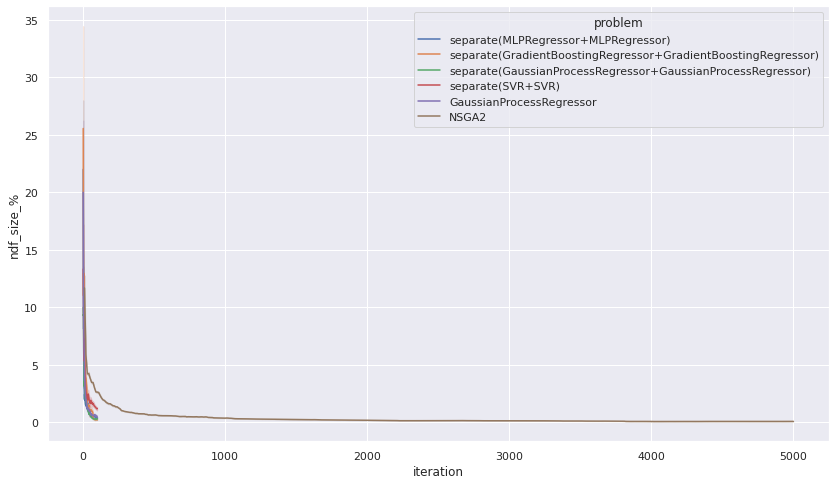

In [429]:
df['ndf_size_%'] = df['ndf_size'] / (df['iteration']*10) * 100
df['test_roc_auc_%'] = df['test_roc_auc'] * 100
df['fit_time_%'] = (1 - df['fit_time'] / df.max()["fit_time"]) * 100





sns.lineplot(x="iteration", 
             y="ndf_size_%", 
             hue="problem",
             data=df)

In [430]:
#integrate ndf_size_% surrogate-wise using the trapezodial rule
df["ndf_size_%_area"] = 0
for p in df.problem.unique():
    problem_wise_df = df[df.problem == p]
    area = np.trapz(y=problem_wise_df["ndf_size_%"])
    df["ndf_size_%_area"] = df["ndf_size_%_area"].where(df.problem != p, area)

In [431]:
# Hypervolume
# find a reference point = [1 - min roc_auc, max fit_time] 
# roc_auc is inversed for minimization

df.max()["fit_time"]
ref_point = np.array([df.max()["test_roc_auc"], df.max()["fit_time"]])
ref_point

array([-0.48584212,  1.71335204])

In [432]:
# raw_df["ndf_f"].apply(lambda x: inverse(x))

In [433]:
raw_df = raw_df.apply(lambda row: compute_hypervolume(row, ref_point), axis=1)

In [445]:
#integrate hypervolume surrogate-wise using the trapezodial rule
import scipy.integrate as integrate

raw_df["hypervolume_area"] = 0
for p in raw_df.problem.unique():
    problem_wise_df = raw_df[raw_df.problem == p]
    area = np.trapz(y=problem_wise_df["hypervolume"])
    raw_df["hypervolume_area"] = raw_df["hypervolume_area"].where(raw_df.problem != p, area)
raw_df[raw_df.problem =="NSGA2"]

,iteration,problem,objectives,feature_dim,ndf_size,ndf_f,ndf_x,i_time,model_id,pop_f,pop_size,i_gen,time,i_fevals,prob_id,hypervolume,hypervolume_area
0,10.0,NSGA2,"[test_roc_auc, fit_time]",NaN,6,"[[-0.860041289538969, 0.04034709930419922], [-...","[[0.40964367574829025, 0.06185135084388535, 0....",NaN,NaN,"[[-0.5, 0.3255525430043538], [-0.8765406588005...",100.0,1.0,1.613900e+09,100.0,1.398908e+14,0.703331,1876.19402
1,20.0,NSGA2,"[test_roc_auc, fit_time]",NaN,12,"[[-0.8718400505220201, 0.04191152254740397], [...","[[0.40964367574829025, 0.06185135084388535, 0....",NaN,NaN,"[[-0.860041289538969, 0.04034709930419922], [-...",100.0,2.0,1.613900e+09,200.0,1.398908e+14,0.719778,1876.19402
2,30.0,NSGA2,"[test_roc_auc, fit_time]",NaN,11,"[[-0.916023835375357, 0.423429012298584], [-0....","[[0.00015188815050537399, 0.026044147519598947...",NaN,NaN,"[[-0.8718400505220201, 0.04191152254740397], [...",100.0,3.0,1.613900e+09,300.0,1.398908e+14,0.730997,1876.19402
3,40.0,NSGA2,"[test_roc_auc, fit_time]",NaN,14,"[[-0.916023835375357, 0.423429012298584], [-0....","[[0.00015188815050537399, 0.026044147519598947...",NaN,NaN,"[[-0.916023835375357, 0.423429012298584], [-0....",100.0,4.0,1.613900e+09,400.0,1.398908e+14,0.732699,1876.19402
4,50.0,NSGA2,"[test_roc_auc, fit_time]",NaN,18,"[[-0.916023835375357, 0.423429012298584], [-0....","[[0.00015188815050537399, 0.026044147519598947...",NaN,NaN,"[[-0.916023835375357, 0.423429012298584], [-0....",100.0,5.0,1.613900e+09,500.0,1.398908e+14,0.734001,1876.19402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4960.0,NSGA2,"[test_roc_auc, fit_time]",NaN,57,"[[-0.8443766646269101, 0.013511896133422852], ...","[[0.4517224340579254, 0.0008913808942160532, 0...",NaN,NaN,"[[-0.8443766646269101, 0.013511896133422852], ...",100.0,496.0,1.613912e+09,49600.0,1.405035e+14,0.757362,1876.19402
496,4970.0,NSGA2,"[test_roc_auc, fit_time]",NaN,58,"[[-0.8443766646269101, 0.013511896133422852], ...","[[0.4517224340579254, 0.0008913808942160532, 0...",NaN,NaN,"[[-0.8443766646269101, 0.013511896133422852], ...",100.0,497.0,1.613912e+09,49700.0,1.405035e+14,0.757362,1876.19402
497,4980.0,NSGA2,"[test_roc_auc, fit_time]",NaN,60,"[[-0.8443766646269101, 0.013511896133422852], ...","[[0.4517224340579254, 0.0008913808942160532, 0...",NaN,NaN,"[[-0.8443766646269101, 0.013511896133422852], ...",100.0,498.0,1.613912e+09,49800.0,1.405035e+14,0.757362,1876.19402
498,4990.0,NSGA2,"[test_roc_auc, fit_time]",NaN,58,"[[-0.8443766646269101, 0.013511896133422852], ...","[[0.4517224340579254, 0.0008913808942160532, 0...",NaN,NaN,"[[-0.8443766646269101, 0.013511896133422852], ...",100.0,499.0,1.613912e+09,49900.0,1.405035e+14,0.758009,1876.19402


<AxesSubplot:xlabel='i_fevals', ylabel='hypervolume'>

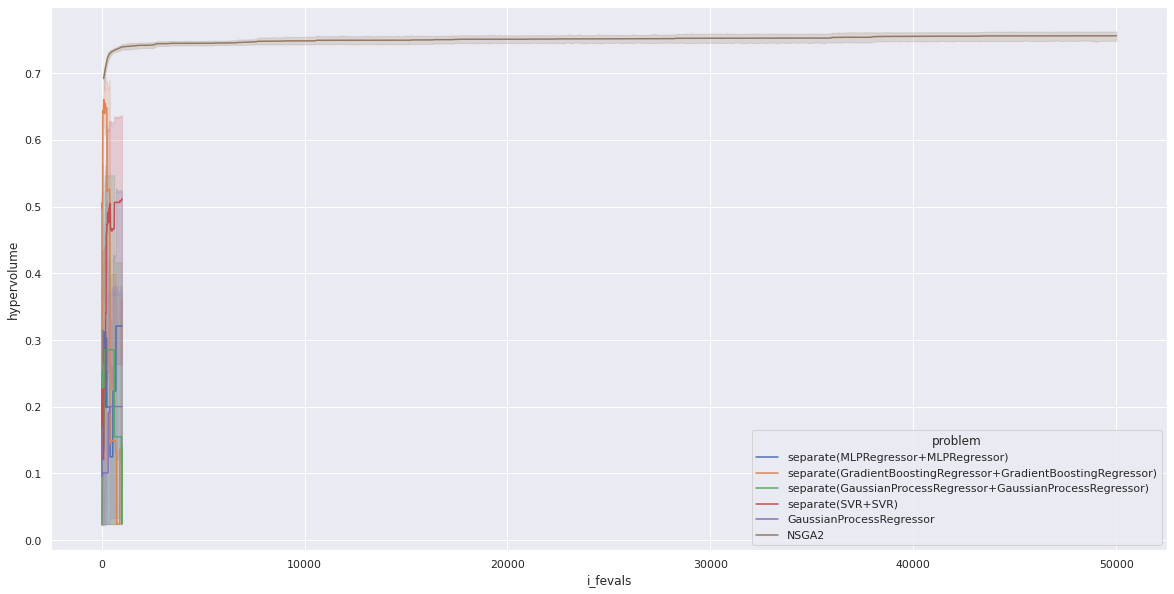

In [435]:
f, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(x="i_fevals", 
             y="hypervolume", 
             hue="problem",
             data=raw_df)

# sns.lineplot(x="iteration", 
#              y="test_roc_auc_%", 
# #              hue="model_id",
#              data=df)

# sns.lineplot(x="iteration", 
#              y="fit_time_%", 
# #              hue="model_id",
#              data=df)

# plt.legend(loc='upper left', labels=['ndf_size_%', 'test_roc_auc_%', 'fit_time_%'])

In [452]:
df_for_merge = df.drop(columns=["params"])
df_for_merge = df_for_merge.dropna(axis=1)

,iteration,problem,ndf_size,i_fevals,test_roc_auc,fit_time,dataset,ndf_size_%,test_roc_auc_%,fit_time_%,ndf_size_%_area
0,1.0,separate(MLPRegressor+MLPRegressor),1,10.0,-0.500000,0.160740,1049,10.0,-50.000000,90.618396,2451.088274
1,2.0,separate(MLPRegressor+MLPRegressor),4,20.0,-0.500000,0.160740,1049,20.0,-50.000000,90.618396,2451.088274
2,2.0,separate(MLPRegressor+MLPRegressor),4,20.0,-0.842515,0.029761,1049,20.0,-84.251545,98.262987,2451.088274
3,2.0,separate(MLPRegressor+MLPRegressor),4,20.0,-0.870934,0.027118,1049,20.0,-87.093407,98.417275,2451.088274
4,2.0,separate(MLPRegressor+MLPRegressor),4,20.0,-0.824231,0.027666,1049,20.0,-82.423085,98.385274,2451.088274
...,...,...,...,...,...,...,...,...,...,...,...
103570,100.0,separate(SVR+SVR),17,1000.0,-0.860962,0.126712,1049,1.7,-86.096166,92.604443,6292.609116
103571,100.0,separate(SVR+SVR),17,1000.0,-0.885218,0.127636,1049,1.7,-88.521807,92.550489,6292.609116
103572,100.0,separate(SVR+SVR),17,1000.0,-0.863744,0.119229,1049,1.7,-86.374392,93.041185,6292.609116
103573,100.0,separate(SVR+SVR),17,1000.0,-0.851623,0.133323,1049,1.7,-85.162303,92.218585,6292.609116


In [453]:
raw_for_merge = raw_df.drop(columns=["ndf_f", "ndf_x", "objectives"])
raw_for_merge = raw_for_merge.dropna(axis=1)

,iteration,problem,ndf_size,i_fevals,hypervolume,hypervolume_area
0,1.0,separate(MLPRegressor+MLPRegressor),1,10.0,0.021982,143.868674
1,2.0,separate(MLPRegressor+MLPRegressor),4,20.0,0.649355,143.868674
2,3.0,separate(MLPRegressor+MLPRegressor),5,30.0,0.649355,143.868674
3,4.0,separate(MLPRegressor+MLPRegressor),5,40.0,0.649355,143.868674
4,5.0,separate(MLPRegressor+MLPRegressor),5,50.0,0.649355,143.868674
...,...,...,...,...,...,...
95,96.0,separate(SVR+SVR),17,960.0,0.641677,214.765949
96,97.0,separate(SVR+SVR),17,970.0,0.641677,214.765949
97,98.0,separate(SVR+SVR),17,980.0,0.641677,214.765949
98,99.0,separate(SVR+SVR),17,990.0,0.641677,214.765949


In [456]:
merged_df = df_for_merge.merge(raw_for_merge)
merged_df

,iteration,problem,ndf_size,i_fevals,test_roc_auc,fit_time,dataset,ndf_size_%,test_roc_auc_%,fit_time_%,ndf_size_%_area,hypervolume,hypervolume_area
0,1.0,separate(MLPRegressor+MLPRegressor),1,10.0,-0.500000,0.160740,1049,10.0,-50.000000,90.618396,2451.088274,0.021982,143.868674
1,1.0,separate(MLPRegressor+MLPRegressor),1,10.0,-0.500000,0.160740,1049,10.0,-50.000000,90.618396,2451.088274,0.022928,143.868674
2,1.0,separate(MLPRegressor+MLPRegressor),1,10.0,-0.500000,0.160740,1049,10.0,-50.000000,90.618396,2451.088274,0.023422,143.868674
3,1.0,separate(MLPRegressor+MLPRegressor),1,10.0,-0.500000,0.160740,1049,10.0,-50.000000,90.618396,2451.088274,0.022492,143.868674
4,1.0,separate(MLPRegressor+MLPRegressor),1,10.0,-0.500000,0.093930,1049,10.0,-50.000000,94.517759,2451.088274,0.021982,143.868674
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119864,100.0,separate(SVR+SVR),17,1000.0,-0.860962,0.126712,1049,1.7,-86.096166,92.604443,6292.609116,0.641677,214.765949
119865,100.0,separate(SVR+SVR),17,1000.0,-0.885218,0.127636,1049,1.7,-88.521807,92.550489,6292.609116,0.641677,214.765949
119866,100.0,separate(SVR+SVR),17,1000.0,-0.863744,0.119229,1049,1.7,-86.374392,93.041185,6292.609116,0.641677,214.765949
119867,100.0,separate(SVR+SVR),17,1000.0,-0.851623,0.133323,1049,1.7,-85.162303,92.218585,6292.609116,0.641677,214.765949


In [457]:
# merged_df = df.merge(raw_df)
result_df = merged_df[merged_df.iteration==100]
result_df = result_df.groupby(["problem"]).mean()
result_df

,iteration,ndf_size,i_fevals,test_roc_auc,fit_time,dataset,ndf_size_%,test_roc_auc_%,fit_time_%,ndf_size_%_area,hypervolume,hypervolume_area
problem,,,,,,,,,,,,
GaussianProcessRegressor,100.0,4.230769,1000.0,-0.537456,0.016829,1049.0,0.423077,-53.745552,99.017753,2818.415192,0.178855,83.931120
NSGA2,100.0,26.280899,1000.0,-0.851926,0.074532,1049.0,2.628090,-85.192636,95.649916,27038.273067,0.738962,1876.194020
separate(GaussianProcessRegressor+GaussianProcessRegressor),100.0,3.482759,1000.0,-0.546534,0.021778,1049.0,0.348276,-54.653396,98.728898,1568.170545,0.183306,109.197812
separate(GradientBoostingRegressor+GradientBoostingRegressor),100.0,2.085714,1000.0,-0.537866,0.015580,1049.0,0.208571,-53.786604,99.090655,5304.989713,0.152549,150.323777
separate(MLPRegressor+MLPRegressor),100.0,4.071429,1000.0,-0.562962,0.020398,1049.0,0.407143,-56.296158,98.809494,2451.088274,0.428539,143.868674
separate(SVR+SVR),100.0,12.191489,1000.0,-0.771413,0.118173,1049.0,1.219149,-77.141281,93.102803,6292.609116,0.609054,214.765949


<AxesSubplot:xlabel='test_roc_auc', ylabel='fit_time'>

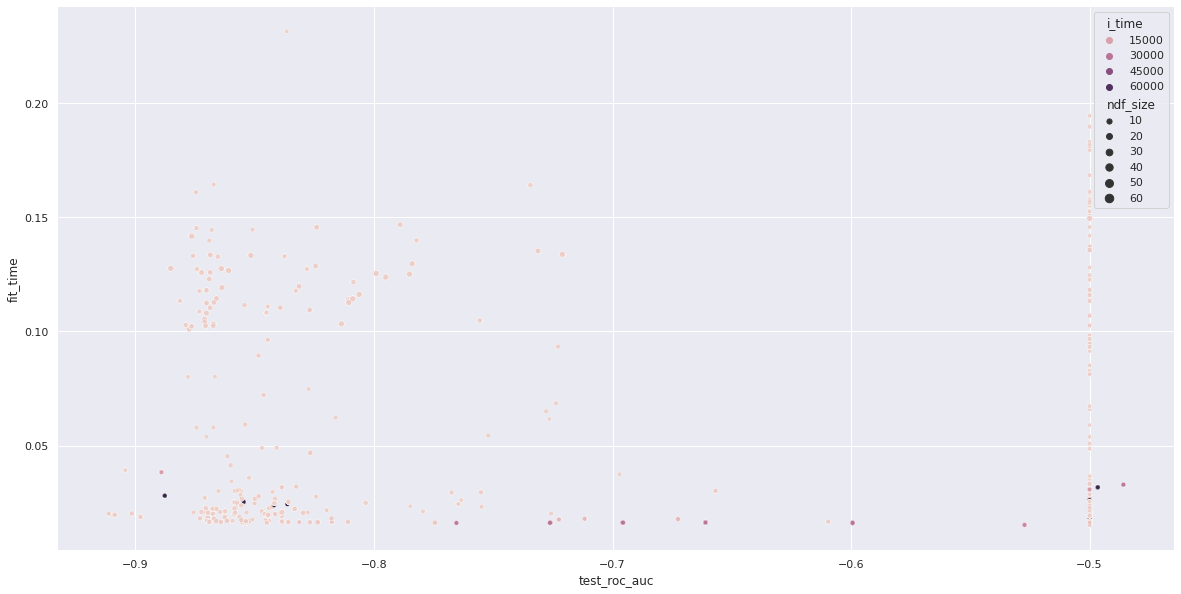

In [458]:
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="test_roc_auc", y="fit_time",
                hue="i_time", size="ndf_size",
                data=df, ax=ax)

## Final results: all samples

In [459]:
data = get_data("results_paper/open_ml_1049/dataset.*.pkl")
data

,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,n_estimators,fit_time,score_time,test_f1,test_roc_auc
0,gini,61.000000,0.500000,0.250000,0.250000,sqrt,505,0.710772,0.094134,0.000000,0.858696
1,entropy,31.000000,0.750000,0.125000,0.375000,sqrt,752,0.972053,0.133970,0.000000,0.500000
2,gini,90.000000,0.250000,0.375000,0.125000,log2,257,0.373163,0.071908,0.000000,0.500000
3,gini,46.000000,0.625000,0.062500,0.437500,log2,133,0.186023,0.028879,0.000000,0.836822
4,entropy,105.000000,0.125000,0.312500,0.187500,sqrt,628,0.862586,0.116507,0.000000,0.788737
...,...,...,...,...,...,...,...,...,...,...,...
1005,entropy,59.098832,0.000047,0.000853,0.273343,sqrt,509,0.850374,0.114520,0.000000,0.875320
1006,entropy,58.341801,0.037465,0.000026,0.000225,sqrt,510,1.232074,0.106525,0.303726,0.931420
1007,entropy,59.098832,0.000018,0.013516,0.190025,sqrt,510,0.811232,0.100302,0.000000,0.882423
1008,entropy,59.655936,0.000018,0.000853,0.208446,sqrt,509,0.802147,0.100319,0.000000,0.877145


<AxesSubplot:xlabel='test_roc_auc', ylabel='fit_time'>

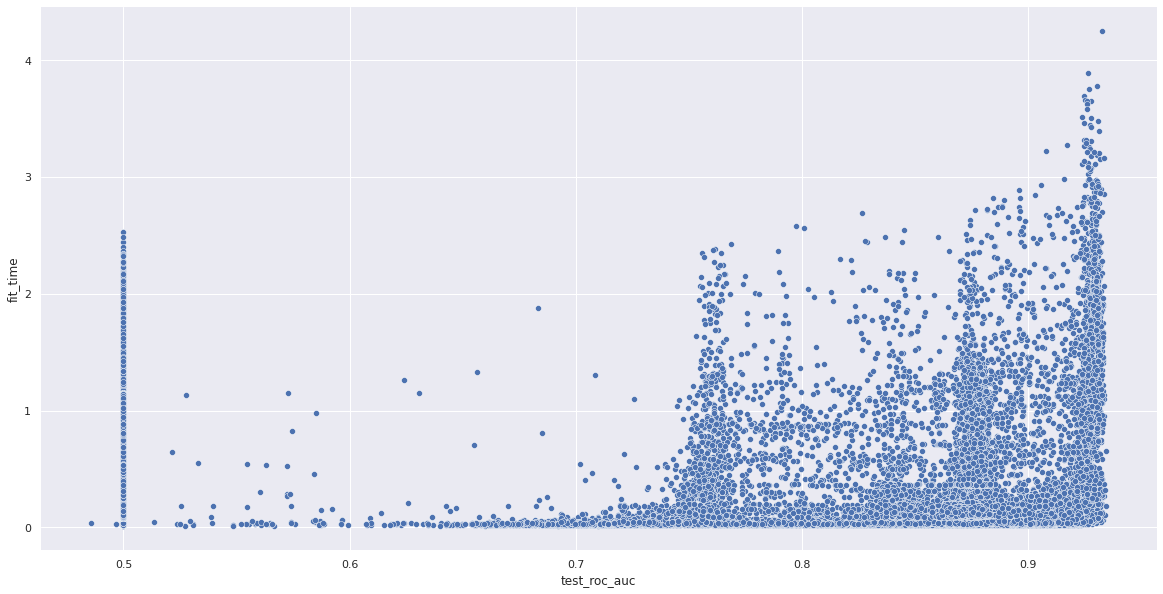

In [460]:
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="test_roc_auc", y="fit_time",
                data=data, ax=ax)

In [466]:
### Table dataset-wise
# datasets = [1049, 1050, 31, 1471, 1510]
datasets = [1049, 31, 1510]

final_result = pd.DataFrame()
for d in datasets:
    raw_df = get_data("results_paper/open_ml_" + str(d) + "/*RF*.pkl")
    raw_df = raw_df.apply(lambda x: resolve_iterations(x), axis=1)
    raw_df["ndf_f"].apply(lambda x: inverse(x))
    raw_df = raw_df.apply(lambda x: resolve_name(x), axis=1)
    
    df = get_data("results_paper/open_ml_" + str(d) + "/*RF*.pkl")
    df = explode_ndf(df)
    df['ndf_size_%'] = df['ndf_size'] / (df['iteration']*10) * 100
    df['test_roc_auc_%'] = df['test_roc_auc'] * 100
    df['fit_time_%'] = (1 - df['fit_time'] / df.max()["fit_time"]) * 100
    df['dataset'] = d
    df = df.apply(lambda x: resolve_iterations(x), axis=1)
    df["test_roc_auc"] = df["test_roc_auc"].apply(lambda x: inverse_float(x))
    df = df.apply(lambda x: resolve_name(x), axis=1)

    
    #integrate ndf_size_% surrogate-wise using the trapezodial rule
    df["ndf_size_%_area"] = 0
    for p in df.problem.unique():
        problem_wise_df = df[df.problem == p]
        area = np.trapz(y=problem_wise_df["ndf_size_%"])
        df["ndf_size_%_area"] = df["ndf_size_%_area"].where(df.problem != p, area)
    # Hypervolume
    # find a reference point = [1 - min roc_auc, max fit_time] 
    # roc_auc is inversed for minimization

    df.max()["fit_time"]
    ref_point = np.array([df.max()["test_roc_auc"], df.max()["fit_time"]])
    raw_df["ndf_f"].apply(lambda x: inverse(x))
    raw_df = raw_df.apply(lambda row: compute_hypervolume(row, ref_point), axis=1)
    #integrate hypervolume surrogate-wise using the trapezodial rule
    raw_df["hypervolume_area"] = 0
    for p in raw_df.problem.unique():
        problem_wise_df = raw_df[raw_df.problem == p]
        area = np.trapz(y=problem_wise_df["hypervolume"])
        raw_df["hypervolume_area"] = raw_df["hypervolume_area"].where(raw_df.problem != p, area)
    
    df_for_merge = df.dropna(axis=1)
    df_for_merge = df_for_merge.drop(columns=["params"])
    raw_for_merge = raw_df.dropna(axis=1)
    raw_for_merge = raw_for_merge.drop(columns=["ndf_f", "ndf_x", "objectives"])
    merged_df = df_for_merge.merge(raw_for_merge)
    result_df = merged_df[merged_df.iteration==100]
    result_df = result_df.groupby(["problem", 'dataset']).mean()
    final_result = pd.concat([final_result, result_df])
final_result    


,,iteration,ndf_size,i_fevals,test_roc_auc,fit_time,test_roc_auc_%,fit_time_%,hypervolume,hypervolume_area
problem,dataset,,,,,,,,,
GaussianProcessRegressor,1049,100.0,4.230769,1000.0,-0.537456,0.016829,53.745552,99.017753,0.178855,83.931120
NSGA2,1049,100.0,26.280899,1000.0,-0.851926,0.074532,-85.192636,95.649916,0.738962,1876.194020
separate(GaussianProcessRegressor+GaussianProcessRegressor),1049,100.0,3.482759,1000.0,-0.546534,0.021778,54.653396,98.728898,0.183306,109.197812
separate(GradientBoostingRegressor+GradientBoostingRegressor),1049,100.0,2.085714,1000.0,-0.537866,0.015580,53.786604,99.090655,0.152549,150.323777
separate(MLPRegressor+MLPRegressor),1049,100.0,4.071429,1000.0,-0.562962,0.020398,56.296158,98.809494,0.428539,143.868674
separate(SVR+SVR),1049,100.0,12.191489,1000.0,-0.771413,0.118173,77.141281,93.102803,0.609054,214.765949
GaussianProcessRegressor,31,100.0,7.186047,1000.0,-0.532479,0.027085,53.247861,97.933023,0.192440,104.847035
NSGA2,31,100.0,23.769231,1000.0,-0.734495,0.096674,-73.449487,92.622330,0.414080,1078.651337
separate(GaussianProcessRegressor+GaussianProcessRegressor),31,100.0,7.857143,1000.0,-0.589438,0.019624,58.943763,98.502403,0.345148,120.878873


In [467]:
# group all datasets
final_result = final_result.groupby(["problem"]).mean()
final_result 

,iteration,ndf_size,i_fevals,test_roc_auc,fit_time,test_roc_auc_%,fit_time_%,hypervolume,hypervolume_area
problem,,,,,,,,,
GaussianProcessRegressor,100.0,6.083383,1000.0,-0.579227,0.020068,57.922703,98.541412,0.265706,103.598767
NSGA2,100.0,24.293306,1000.0,-0.837519,0.066550,-83.751915,95.318703,0.580791,1481.261014
separate(GaussianProcessRegressor+GaussianProcessRegressor),100.0,5.700602,1000.0,-0.605664,0.019644,60.566361,98.601305,0.313520,101.621442
separate(GradientBoostingRegressor+GradientBoostingRegressor),100.0,4.361905,1000.0,-0.627002,0.015540,62.700176,98.880489,0.247398,133.371060
separate(MLPRegressor+MLPRegressor),100.0,3.650590,1000.0,-0.525391,0.019404,52.539064,98.611339,0.181909,83.830353
separate(SVR+SVR),100.0,12.185360,1000.0,-0.740868,0.138277,74.086803,89.950035,0.491278,150.994091
